## Named entity recognition in spaCy
Kate Riesbeck  
19 May 2020  
  
   
This notebook reviews named entity recognition (NER) in spaCy with:
* Pretrained spaCy models
* Customized NER with:
 * Rule-based matching
 * Custom trained models

### Setup

pip install requirements.txt

In [1]:
import spacy
from spacy import displacy
from IPython.display import Image

### NER with spaCy's pretrained models

In [2]:
# load a pretrained spaCy model

nlp = spacy.load('en_core_web_sm')

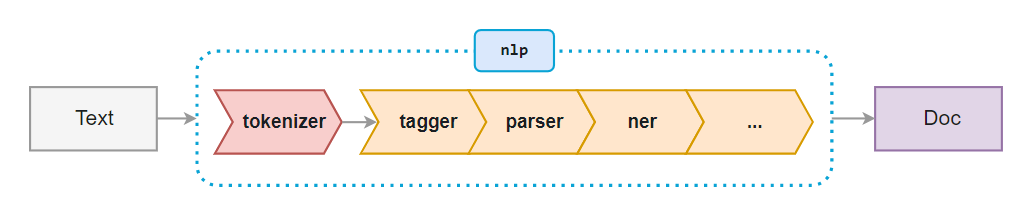

In [3]:
Image(filename = 'images/pipeline.png', width=1000, height=1000)

In [4]:
# the pretrained model comes with a default processing pipeline
# includes part-of-speech tagging, syntactic parsing, and NER
# pretrained models are statistical and every “decision” they make is a prediction
# this prediction is based on the examples the model has seen during training

nlp.pipe_names

['tagger', 'parser', 'ner']

In [5]:
text = """George Washington (February 22, 1732[b] – December 14, 1799) was an American political leader, 
military general, statesman, and founding father who served as the first president of the United States 
from 1789 to 1797. Previously, he led Patriot forces to victory in the nation's War for Independence. 
He presided at the Constitutional Convention of 1787, which established the U.S. Constitution and a federal government. 
Washington has been called the "Father of His Country" for his manifold leadership in the formative days of the new nation.
"""

In [6]:
# run the text through the pretrained model

doc = nlp(text)

In [7]:
# the NER pipeline component tags entities in the doc with various attributes

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Washington 0 17 PERSON
February 22 19 30 DATE
December 14, 1799 42 59 DATE
American 68 76 NORP
first 163 168 ORDINAL
the United States 182 199 GPE
1789 to 1797 206 218 DATE
Patriot 239 246 PERSON
War for Independence 281 301 EVENT
the Constitutional Convention 319 348 LAW
1787 352 356 DATE
the U.S. Constitution 376 397 LAW
Washington 425 435 GPE
the "Father of His Country" 452 479 LAW
the formative days 511 529 DATE


In [8]:
# use displacy to visualize entities

displacy.render(doc, style='ent')

### How can I customize NER in spaCy for my use case?

1. Add rule-based matching
 * Useful if there’s a finite number of examples that you want to find in the data, or if there’s a very clear, structured pattern
 * For instance, country names, IP addresses or URLs
2. Train a custom model
 * Useful if you have examples and you want your system to generalize based on those examples
 * Works especially well if there are clues in the local context
 * For instance, person or company names

You can also combine both approaches and improve a model with rules to handle very specific cases and boost accuracy.

### Rule-based matching with EntityRuler

SpaCy's EntityRuler is a pipeline component that lets you add named entities based on pattern dictionaries, and makes it easy to combine rule-based and statistical NER for more powerful models.


The entity ruler integrates with spaCy’s existing statistical models and enhances the named entity recognizer. 



In [9]:
from spacy.pipeline import EntityRuler

In [10]:
ruler = EntityRuler(nlp)

In [11]:
#### PATTERNS

# https://spacy.io/api/entityruler#add_patterns

# Entity Patterns

# Entity patterns are dictionaries with two keys: 
# 1. "label", the label to assign to the entity
# 2. "pattern", the match pattern. 

# The entity ruler accepts two types of patterns:
# 1. Phrase patterns for exact string matches
# 2. Token patterns with one pattern dictionary per token

In [12]:
# **Phrase patterns**

# Here is a phrase pattern example:
# patterns = [{"label": "PRES", "pattern": "George Washington"}]

In [13]:
ruler.add_patterns([{"label": "PRES", "pattern": "George Washington"}])

In [14]:
# Add EntityRuler pipeline component to the nlp model pipeline before the existing 'ner' pipeline

# Important: If the EntityRuler is added before the "ner" component,'ner' will respect the EntityRuler labels 
# and adjust its predictions.  This is what we want.

# If it’s added after the "ner" component, the EntityRuler will only tag entities if they don’t overlap 
# with entities predicted by 'ner'. To overwrite overlapping entities, you can set overwrite_ents=True on initialization.

nlp.add_pipe(ruler, before='ner', name='presidents')

In [15]:
nlp.pipe_names

['tagger', 'parser', 'presidents', 'ner']

In [16]:
# run the text through the new model pipeline

doc = nlp(text)

In [17]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Washington 0 17 PRES
February 22 19 30 DATE
December 14, 1799 42 59 DATE
American 68 76 NORP
first 163 168 ORDINAL
the United States 182 199 GPE
1789 to 1797 206 218 DATE
Patriot 239 246 PERSON
War for Independence 281 301 EVENT
the Constitutional Convention 319 348 LAW
1787 352 356 DATE
the U.S. Constitution 376 397 LAW
Washington 425 435 GPE
the "Father of His Country" 452 479 LAW
the formative days 511 529 DATE


In [18]:
displacy.render(doc, style='ent')

In [19]:
# Let's add more patterns
# Starting with a list of president names
presidents = ["Donald Trump" , "Barack Obama" , "George W. Bush" , "Bill Clinton" , "George H.W. Bush" , "Ronald Reagan" , "Jimmy Carter" , "Gerald Ford" , "Richard Nixon" , "Lyndon B. Johnson" , "John F. Kennedy" , "Dwight D. Eisenhower", "Harry S. Truman" , "Franklin D. Roosevelt" , "Herbert Hoover" , "Calvin Coolidge" , "Warren G. Harding" , "Woodrow Wilson" , "Howard Taft" , "Theodore Roosevelt" , "William McKinley" , "Grover Cleveland" , "Benjamin Harrison" , "Grover Cleveland" , "Chester A. Arthur" , "James Garfield" , "Rutherford B. Hayes" , "Ulysses S. Grant" , "Andrew Johnson" , "Abraham Lincoln" , "James Buchanan" , "Franklin Pierce" , "Millard Fillmore", "Zachary Taylor" , "James K. Polk" , "John Tyler" , "William Henry Harrison" , "Martin Van Buren" , "Andrew Jackson" , "John Quincy Adams" , "James Monroe" , "James Madison" , "Thomas Jefferson" , "John Adams"]

In [20]:
# Write a function to turn the list into spaCy's entity pattern list of dictionaries format
def make_patterns(my_list, my_label):
    """
    turns a list of strings into a list of patterns with the same label for spaCy's EntityRuler
    """
    patterns = []
    for i in my_list:
        d = {}
        d['label'] = my_label
        d['pattern'] = i
        patterns.append(d)
    return patterns    

In [21]:
# Create the patterns
patterns = make_patterns(presidents, "PRES")

In [26]:
# Verify pattern format -- a list of dictionaries
patterns[:10]

[{'label': 'PRES', 'pattern': 'Donald Trump'},
 {'label': 'PRES', 'pattern': 'Barack Obama'},
 {'label': 'PRES', 'pattern': 'George W. Bush'},
 {'label': 'PRES', 'pattern': 'Bill Clinton'},
 {'label': 'PRES', 'pattern': 'George H.W. Bush'},
 {'label': 'PRES', 'pattern': 'Ronald Reagan'},
 {'label': 'PRES', 'pattern': 'Jimmy Carter'},
 {'label': 'PRES', 'pattern': 'Gerald Ford'},
 {'label': 'PRES', 'pattern': 'Richard Nixon'},
 {'label': 'PRES', 'pattern': 'Lyndon B. Johnson'}]

In [25]:
# Add the patterns to the EntityRuler pipeline component
ruler.add_patterns(patterns)

In [29]:
# Check to make sure our new patterns were added to the EntityRuler
ruler.patterns[:10]

[{'label': 'PRES', 'pattern': 'George Washington'},
 {'label': 'PRES', 'pattern': 'Donald Trump'},
 {'label': 'PRES', 'pattern': 'Barack Obama'},
 {'label': 'PRES', 'pattern': 'George W. Bush'},
 {'label': 'PRES', 'pattern': 'Bill Clinton'},
 {'label': 'PRES', 'pattern': 'George H.W. Bush'},
 {'label': 'PRES', 'pattern': 'Ronald Reagan'},
 {'label': 'PRES', 'pattern': 'Jimmy Carter'},
 {'label': 'PRES', 'pattern': 'Gerald Ford'},
 {'label': 'PRES', 'pattern': 'Richard Nixon'}]

In [30]:
# Remove existing 'presidents' pipe
nlp.remove_pipe('presidents')

('presidents', <spacy.pipeline.entityruler.EntityRuler at 0x7fc29517ce50>)

In [31]:
# Add updated EntityRuler pipeline component to the nlp model pipeline
nlp.add_pipe(ruler, before='ner', name='presidents')

In [32]:
doc = nlp("George H.W. Bush (June 12, 1924 – November 30, 2018) was an American politician and businessman \
          who served as the 41st president of the United States from 1989 to 1993.")

In [33]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George H.W. Bush 0 16 PRES
June 12, 1924 18 31 DATE
November 30, 2018 34 51 DATE
American 60 68 NORP
41st 124 128 ORDINAL
the United States 142 159 GPE
1989 to 1993 165 177 DATE


In [34]:
displacy.render(doc, style='ent')

In [35]:
## 

In [36]:
doc = nlp("George Herbert Walker Bush (June 12, 1924 – November 30, 2018) was an American politician and businessman \
          who served as the 41st president of the United States from 1989 to 1993.")

In [37]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Herbert Walker Bush 0 26 PERSON
June 12, 1924 28 41 DATE
November 30, 2018 44 61 DATE
American 70 78 NORP
41st 134 138 ORDINAL
the United States 152 169 GPE
1989 to 1993 175 187 DATE


In [38]:
displacy.render(doc, style='ent')

In [39]:
# remove existing 'presidents' pipe and reset EntityRuler

nlp.remove_pipe('presidents')

ruler = EntityRuler(nlp)

patterns = []

In [40]:
# **Token patterns**

# 

# patterns = [{"label": "PRES", "pattern": "George H.W. Bush"},
#            {"label": "VP", "pattern": [{"LOWER": "al"}, {"LOWER": "gore"}]}]


In [41]:
# we can craft more inclusive patterns with regex
# note the ruler evaluates by token

In [42]:
# 2 tokens (like george bush)
patterns.append({"id":"PRES41", "label": "PRES", "pattern": [{"LOWER": 'george'}, {"LOWER": 'bush'}]})

# 3 tokens (like george hw bush, george h.w. bush)
patterns.append({"id":"PRES41", "label": "PRES", "pattern": [{"LOWER": {"REGEX": 'george'}}, {"LOWER": {"REGEX": '(h(w|.w.)?)'}}, {"LOWER": {"REGEX": 'bush'}}]})

# 4 tokens (like george h w bush, george h. w. bush, george herbert walker bush)
patterns.append({"id":"PRES41", "label": "PRES", "pattern": [{"LOWER": {"REGEX": 'george'}}, {"LOWER": {"REGEX": '(h(.|erbert)?)'}}, {"LOWER": {"REGEX": '(w(.|alker)?)'}}, {"LOWER": {"REGEX": 'bush'}}]})

In [43]:
ruler.add_patterns(patterns)

In [44]:
nlp.add_pipe(ruler, before='ner', name='presidents')

In [45]:
doc = nlp("George Herbert Walker Bush was an American politician and businessman \
          who served as the 41st president of the United States from 1989 to 1993. \
          His son, George W. Bush, served as the 43rd president of the United States. \
          Known names: George H.W. Bush, George H. W. Bush, George Bush, George HW Bush, George H W Bush")

In [46]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Herbert Walker Bush 0 26 PRES
American 34 42 NORP
41st 98 102 ORDINAL
the United States 116 133 GPE
1989 to 1993 139 151 DATE
George W. Bush 172 186 PERSON
43rd 202 206 ORDINAL
the United States 220 237 GPE
George H.W. Bush 262 278 PRES
George H. W. Bush 280 297 PRES
George Bush 299 310 PRES
George HW Bush 312 326 PRES
George H W Bush 328 343 PRES


In [47]:
displacy.render(doc, style='ent')

### Train a custom model

In [ ]:
# Note: If you're using an existing model, make sure to mix in examples of
# other entity types that spaCy correctly recognized before. Otherwise, your
# model might learn the new type, but "forget" what it previously knew.
# https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting

In [ ]:
# https://github.com/DataTurks-Engg/Entity-Recognition-In-Resumes-SpaCy

# spaCy’s models are statistical and every “decision” they make whether a word is a named entity is a prediction. 
# This prediction is based on the examples the model has seen during training.

# The model is then shown the unlabelled text and will make a prediction. 
# Because we know the correct answer, we can give the model feedback on its prediction in the form of an error gradient of the loss function that calculates the difference between the training example and the expected output. 
# The greater the difference, the more significant the gradient and the updates to our model.

# When training a model, we don’t just want it to memorise our examples — 
# we want it to come up with theory that can be generalised across other examples. 
# After all, we don’t just want the model to learn that this one instance of “Amazon” right here is a company — 
# we want it to learn that “Amazon”, in contexts like this, is most likely a company. 
# In order to tune the accuracy, we process our training examples in batches, 
# and experiment with minibatch sizes and dropout rates.

# Of course, it’s not enough to only show a model a single example once. 
# Especially if you only have few examples, you’ll want to train for a number of iterations. 
# At each iteration, the training data is shuffled to ensure the model doesn’t make any generalisations 
# based on the order of examples.

# Another technique to improve the learning results is to set a dropout rate, 
# a rate at which to randomly “drop” individual features and representations. 
# This makes it harder for the model to memorise the training data. 
# For example, a 0.25dropout means that each feature or internal representation has a 1/4 likelihood of being dropped. 
# We train the model for 10 epochs and keep the dropout rate as 0.2.

In [ ]:
Results and Evaluation of the model :
The model is tested on 20 resumes and the predicted summarized resumes are stored as separate .txt files for each resume.

For each resume on which the model is tested, we calculate the accuracy score, precision, recall and f-score for each entity that the model recognizes. The values of these metrics for each entity are summed up and averaged to generate an overall score to evaluate the model on the test data consisting of 20 resumes. The entity wise evaluation results can be observed below . It is observed that the results obtained have been predicted with a commendable accuracy.



### Prodigy

In [ ]:
### Conclusion

In [ ]:
### Resources


In [ ]:
# replace requirements.txt